In [1]:
import gc
import os

import pandas as pd
import numpy as np
import warnings
import pickle
import polars as pl

from collections import defaultdict
from itertools import combinations
import pyarrow as pa

from xgboost import XGBClassifier

# from lightgbm import LGBMClassifier
# from lightgbm import early_stopping
# from lightgbm import log_evaluation

from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve


import matplotlib.pyplot as plt
import seaborn as sns
# from colorama import Fore, Back, Style


from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [2]:

# Set max display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data preprocessing

In [3]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = [
        'hover_duration', 'elapsed_time_diff','room_coor_diff', 'screen_coor_diff','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',] #'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [4]:
columns = [

    #pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    # (
    #     (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
    #      .abs()
    #      .over(["session_id", "level_group"])
    #     .alias("location_x_diff") 
    # ),
    # (
    #     (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
    #      .abs()
    #      .over(["session_id", "level_group"])
    #     .alias("location_y_diff") 
    # ),
    (
        ((pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) ** 2 
        + (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) ** 2)
        .sqrt()
        .over(["session_id", "level_group"])
        .alias("screen_coor_diff")
    ),
    (
        ((pl.col("room_coor_x") - pl.col("room_coor_x").shift(1)) ** 2 
        + (pl.col("room_coor_y") - pl.col("room_coor_y").shift(1)) ** 2)
        .sqrt()
        .over(["session_id", "level_group"])
        .alias("room_coor_diff")
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
]

In [5]:
%%time

# we prepare the dataset for the training by level :
df = (pl.read_csv("data/predict-student-performance-from-game-play/train.csv")
      .drop(["fullscreen", "hq", "music","page"])
      .with_columns(columns))

# df1 = df.filter(pl.col("level_group")=='0-4')
# df2 = df.filter(pl.col("level_group")=='5-12')
# df3 = df.filter(pl.col("level_group")=='13-22')
# df1.shape,df2.shape,df3.shape

CPU times: user 20.7 s, sys: 15.7 s, total: 36.4 s
Wall time: 8.79 s


# Old Gen

In [7]:
# def feature_engineer(x, grp, use_extra, feature_suffix):
#     aggs = [
#         pl.col("index").count().alias(f"session_number_{feature_suffix}"),

#         *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

#         *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
#         *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
#         *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
#         *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
#         *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS],

#         *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
#           for c in fqid_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
#           c in fqid_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
#           c in fqid_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
#           c in fqid_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
#           c in fqid_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
#           c in fqid_lists],


#         *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for
#           c in text_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
#           c in text_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
#           c in text_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
#           c in text_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
#           c in text_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
#           c in text_lists],

#         *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
#           for c in room_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
#           c in room_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
#           c in room_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
#           c in room_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
#           c in room_lists],
#         *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
#           c in room_lists],

#         *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
#           for c in event_name_feature],
#         *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}")for
#           c in event_name_feature],
#         *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
#           c in event_name_feature],
#         *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
#           c in event_name_feature],
#         *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
#           c in event_name_feature],
#         *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
#           c in event_name_feature],

#         *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
#           name_feature],
#         *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
#           name_feature],
#         *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
#           name_feature],
#         *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
#           name_feature],
#         *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
#           name_feature],
#         *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
#           name_feature],

#         *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
#         *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
#           LEVELS],
#         *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
#           LEVELS],
#         *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
#           LEVELS],
#         *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
#           LEVELS],
#         *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
#           LEVELS],

#         *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(f"{c}_LEVEL_group_count{feature_suffix}") for c in
#           level_groups],
#         *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
#           level_groups],
#         *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
#           level_groups],
#         *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
#           level_groups],
#         *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
#           level_groups],
#         *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
#           level_groups],

#         *[pl.col("index").filter((pl.col("level") == c) & (pl.col('room_fqid') == d)).count().alias(f"{c}{d}_level_room_count{feature_suffix}") for c in LEVELS for d in room_lists],


#     ]

#     df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

#     if use_extra:
#         if grp == '5-12':
#             aggs = [
#                 pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")
#                                               |(pl.col("fqid")=='logbook.page.bingo'))
#                     .apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
#                 pl.col("index").filter(
#                     (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
#                     lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
#                 pl.col("elapsed_time").filter(
#                     ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
#                                 pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
#                     "reader_bingo_duration"),
#                 pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
#                             pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
#                     "reader_bingo_indexCount"),
#                 pl.col("elapsed_time").filter(
#                     ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
#                                 pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
#                     "journals_bingo_duration"),
#                 pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
#                             pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
#                     "journals_bingo_indexCount"),
#             ]
#             tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
#             df = df.join(tmp, on="session_id", how='left')

#         if grp == '13-22':
#             aggs = [
#                 pl.col("elapsed_time").filter(
#                     ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
#                                 pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
#                     lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
#                 pl.col("index").filter(
#                     ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
#                                 pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
#                     lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
#                 pl.col("elapsed_time").filter(
#                     ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
#                                 pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
#                     lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
#                 pl.col("index").filter(
#                     ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
#                                 pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
#                     lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
#             ]
#             tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
#             df = df.join(tmp, on="session_id", how='left')

#     return df.to_pandas()

# New feature gen

In [7]:
def create_aggregations(column, conditions, stats, feature_suffix):
    aggs = []
    filtered_column = pl.col(column).filter(conditions)
    for stat in stats:
        if stat == 'count':
            aggs.append(filtered_column.count().alias(f"{column}_count_{feature_suffix}"))
        elif stat == 'mean':
            aggs.append(filtered_column.mean().alias(f"{column}_mean_{feature_suffix}"))
        elif stat == 'median':
            aggs.append(filtered_column.median().alias(f"{column}_median_{feature_suffix}"))
        elif stat == 'std':
            aggs.append(filtered_column.std().alias(f"{column}_std_{feature_suffix}"))
        elif stat == 'min':
            aggs.append(filtered_column.min().alias(f"{column}_min_{feature_suffix}"))
        elif stat == 'max':
            aggs.append(filtered_column.max().alias(f"{column}_max_{feature_suffix}"))
        elif stat == 'sum':
            aggs.append(filtered_column.sum().alias(f"{column}_sum_{feature_suffix}"))
    return aggs

def feature_engineer(x, grp, use_extra, feature_suffix):
    stats = ['count', 'mean', 'std', 'min', 'max', 'sum']

        # Select the data based on 'level_group'
    if grp == '0-4':
        df = x.filter(pl.col("level_group") == '0-4')
    elif grp == '5-12':
        df = x.filter(pl.col("level_group") == '5-12')
    elif grp == '13-22':
        df = x.filter(pl.col("level_group") == '13-22')
    else:
        raise ValueError("Invalid level group. Please select from ['0-4', '5-12', '13-22']")

    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS]
    ]



    for feature_list, column_name in [(fqid_lists, "fqid"), #(text_lists, "text_fqid"), (room_lists, "room_fqid"),
                                      (LEVELS, "level"),(level_groups, "level_group"),  #(event_name_feature, "event_name"), (name_feature, "name"), 
                                      ]: #
        for c in feature_list:
            conditions = pl.col(column_name) == c
            aggs.extend(create_aggregations("elapsed_time_diff", conditions, stats, f"{c}_{feature_suffix}"))


    # # Special case for level and room_lists
    # for c in LEVELS:
    #     for d in room_lists:
    #         conditions = (pl.col("level") == c) & (pl.col("room_fqid") == d)
    #         aggs.append(pl.col("index").filter(conditions).count().alias(f"{c}{d}_level_room_count{feature_suffix}"))

    df = x.groupby(['session_id','level'], maintain_order=True).agg(aggs).sort("session_id")

    df_pivot = df.pivot(
    index='session_id',
    columns='level',
    values= [col for col in df.columns if col not in ['session_id', 'level']],
    aggregate_function = None,
    maintain_order = True,
    separator = '_'
    )


    return df_pivot.to_pandas()

In [8]:
%%time
df1_features = feature_engineer(df, grp='0-4', use_extra=False, feature_suffix='_')
print('df1_features done',df1_features.shape)
df2_features = feature_engineer(df, grp='5-12', use_extra=False, feature_suffix='_')
print('df2_features done',df2_features.shape)
df3_features = feature_engineer(df, grp='13-22', use_extra=False, feature_suffix='_')
print('df3_features done',df3_features.shape)

df1_features done (23562, 22219)
df2_features done (23562, 22219)
df3_features done (23562, 22219)
CPU times: user 11min 22s, sys: 1min 28s, total: 12min 51s
Wall time: 1min


# Saving the data

In [10]:
# df1.to_parquet('df1.parquet')
# df2.to_parquet('df2.parquet')
# df3.to_parquet('df3.parquet')

# Cleaning the data

In [9]:
# some cleaning...
null1 = df1_features.isnull().sum().sort_values(ascending=False) / len(df1_features)
print(null1)
null2 = df2_features.isnull().sum().sort_values(ascending=False) / len(df2_features)
print(null2)
null3 = df3_features.isnull().sum().sort_values(ascending=False) / len(df3_features)
print(null3)

drop1 = list(null1[null1>0.5].index)
drop2 = list(null2[null2>0.5].index)
drop3 = list(null3[null3>0.5].index)
print(len(drop1), len(drop2), len(drop3))

for col in df1_features.columns:
    if df1_features[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2_features.columns:
    if df2_features[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3_features.columns:
    if df3_features[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")


df1_features = df1_features.set_index('session_id')
df2_features = df2_features.set_index('session_id')
df3_features = df3_features.set_index('session_id')

FEATURES1 = [c for c in df1_features.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2_features.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3_features.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1_features.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

elapsed_time_diff_mean_fox___1                1.0
elapsed_time_diff_std_tunic.hub.slip___0      1.0
elapsed_time_diff_min_block_0___10            1.0
elapsed_time_diff_mean_tunic.hub.slip___4     1.0
elapsed_time_diff_mean_tunic.hub.slip___10    1.0
                                             ... 
elapsed_time_diff_count_tocage___12           0.0
elapsed_time_diff_count_tocage___11           0.0
elapsed_time_diff_count_tocage___10           0.0
elapsed_time_diff_count_tocage___9            0.0
elapsed_time_diff_sum_13-22___22              0.0
Length: 22219, dtype: float64
elapsed_time_diff_mean_fox___1                1.0
elapsed_time_diff_std_tunic.hub.slip___0      1.0
elapsed_time_diff_min_block_0___10            1.0
elapsed_time_diff_mean_tunic.hub.slip___4     1.0
elapsed_time_diff_mean_tunic.hub.slip___10    1.0
                                             ... 
elapsed_time_diff_count_tocage___12           0.0
elapsed_time_diff_count_tocage___11           0.0
elapsed_time_diff_co

In [10]:
df1_features[FEATURES1]

,session_number___0,session_number___1,session_number___2,session_number___3,session_number___4,session_number___5,session_number___6,session_number___7,session_number___8,session_number___9,session_number___10,session_number___11,session_number___12,session_number___13,session_number___14,session_number___15,session_number___16,session_number___17,session_number___18,session_number___19,session_number___20,session_number___21,session_number___22,event_name_unique___0,event_name_unique___1,event_name_unique___2,event_name_unique___3,event_name_unique___4,event_name_unique___5,event_name_unique___6,event_name_unique___7,event_name_unique___8,event_name_unique___9,event_name_unique___10,event_name_unique___11,event_name_unique___12,event_name_unique___13,event_name_unique___14,event_name_unique___15,event_name_unique___16,event_name_unique___17,event_name_unique___18,event_name_unique___19,event_name_unique___20,event_name_unique___21,event_name_unique___22,name_unique___0,name_unique___1,name_unique___2,name_unique___3,name_unique___4,name_unique___5,name_unique___6,name_unique___7,name_unique___8,name_unique___9,name_unique___10,name_unique___11,name_unique___12,name_unique___13,name_unique___14,name_unique___15,name_unique___16,name_unique___17,name_unique___18,name_unique___19,name_unique___20,name_unique___21,name_unique___22,fqid_unique___0,fqid_unique___1,fqid_unique___2,fqid_unique___3,fqid_unique___4,fqid_unique___5,fqid_unique___6,fqid_unique___7,fqid_unique___8,fqid_unique___9,fqid_unique___10,fqid_unique___11,fqid_unique___12,fqid_unique___13,fqid_unique___14,fqid_unique___15,fqid_unique___16,fqid_unique___17,fqid_unique___18,fqid_unique___19,fqid_unique___20,fqid_unique___21,fqid_unique___22,room_fqid_unique___1,room_fqid_unique___2,room_fqid_unique___3,room_fqid_unique___5,room_fqid_unique___6,room_fqid_unique___7,room_fqid_unique___8,room_fqid_unique___9,room_fqid_unique___11,room_fqid_unique___12,room_fqid_unique___13,room_fqid_unique___14,room_fqid_unique___15,room_fqid_unique___16,room_fqid_unique___17,room_fqid_unique___18,room_fqid_unique___19,room_fqid_unique___20,room_fqid_unique___21,room_fqid_unique___22,text_fqid_unique___0,text_fqid_unique___1,text_fqid_unique___2,text_fqid_unique___3,text_fqid_unique___4,text_fqid_unique___5,text_fqid_unique___6,text_fqid_unique___7,text_fqid_unique___8,text_fqid_unique___9,text_fqid_unique___10,text_fqid_unique___11,text_fqid_unique___12,text_fqid_unique___13,text_fqid_unique___14,text_fqid_unique___15,text_fqid_unique___16,text_fqid_unique___17,text_fqid_unique___18,text_fqid_unique___19,text_fqid_unique___20,text_fqid_unique___21,text_fqid_unique___22,hover_duration_std___3,hover_duration_std___7,hover_duration_std___8,hover_duration_std___9,hover_duration_std___11,hover_duration_std___18,hover_duration_std___19,hover_duration_std___20,hover_duration_std___21,hover_duration_std___22,elapsed_time_diff_std___0,elapsed_time_diff_std___1,elapsed_time_diff_std___2,elapsed_time_diff_std___3,elapsed_time_diff_std___4,elapsed_time_diff_std___5,elapsed_time_diff_std___6,elapsed_time_diff_std___7,elapsed_time_diff_std___8,elapsed_time_diff_std___9,elapsed_time_diff_std___10,elapsed_time_diff_std___11,elapsed_time_diff_std___12,elapsed_time_diff_std___13,elapsed_time_diff_std___14,elapsed_time_diff_std___15,elapsed_time_diff_std___16,elapsed_time_diff_std___17,elapsed_time_diff_std___18,elapsed_time_diff_std___19,elapsed_time_diff_std___20,elapsed_time_diff_std___21,elapsed_time_diff_std___22,room_coor_diff_std___0,room_coor_diff_std___1,room_coor_diff_std___2,room_coor_diff_std___3,room_coor_diff_std___4,room_coor_diff_std___5,room_coor_diff_std___6,room_coor_diff_std___7,room_coor_diff_std___8,room_coor_diff_std___9,room_coor_diff_std___10,room_coor_diff_std___11,room_coor_diff_std___12,room_coor_diff_std___13,room_coor_diff_std___14,room_coor_diff_std___15,room_coor_diff_std___16,room_coor_diff_std___17,room_coor_diff_std___18,room_coor_diff_std___19,room_coor_diff_std___20

In [11]:
# Saving the lists to a file
with open('XG_boost_models/230611/features_lists.pkl', 'wb') as f:
    pickle.dump({'FEATURES1': FEATURES1, 'FEATURES2': FEATURES2, 'FEATURES3': FEATURES3}, f)

### Grid Search

In [21]:


warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1.shape[0],18))   

best_params_dict = {}

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3_features
        FEATURES = FEATURES3
    
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]



    # Define the parameter grid
    param_grid = {
        #'tree_method': ['gpu_hist'],  
        #'predictor': ['gpu_predictor'],
        'n_estimators': [250, ],  #300, 350, 400, 450, 500
        'learning_rate': [ 0.02, 0.05], # 0.05
        'max_depth': [4, 5, 6], #3, 4, 5
        'subsample': [0.8], #0.6, 0.8, 
        'colsample_bytree': [0.7], #, 0.5, 0.6
        'alpha': [6,8,10], #6, 8, 10
        #'scale_pos_weight': [1.0, scale_pos_weight,] #
    }

    # Initialize the estimator
    xgb_estimator = XGBClassifier(
        booster='gbtree',
        tree_method='hist',
        objective='binary:logistic',
        eval_metric='logloss',
        seed=42
        
    )

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_estimator,
        param_grid=param_grid,
        cv=5,  # Adjust the number of folds to your needs
        scoring='roc_auc',  # Adjust the scoring parameter to your needs
        verbose=1,
        n_jobs=-1  # Use all available CPU cores
    )

    X_train = df[FEATURES].astype('float32').fillna(-1)
    y_train = train_y['correct']

    # Use RandomOverSampler instead of SMOTE
    oversampler = RandomOverSampler(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # # Calculating class weights
    # num_neg = sum(train_y['correct'] == 0)
    # num_pos = sum(train_y['correct'] == 1)
    # scale_pos_weight = num_neg / num_pos

    # smote = SMOTE(random_state=42)
    # X_train = df[FEATURES].astype('float32').fillna(-1)
    # X_train, y_train = smote.fit_resample(X_train, train_y['correct'])

    # Fit GridSearchCV using the balanced dataset
    grid_search.fit(X_train, y_train)


    # Get the best parameters
    best_params = grid_search.best_params_

    # Save the best parameters
    best_params_dict[t] = best_params


    # # Variables
    # X_train = df[FEATURES].astype('float32')
    # #X_val = df_valid[FEATURES].astype('float32')
    # y_train = train_y['correct']
    # #y_val = valid_y['correct']

    # Calculate performance metrics on a validation set
    # Assuming you have a validation set split already: X_val, y_val
    y_pred = grid_search.predict(X_train)
    y_proba = grid_search.predict_proba(X_train)[:, 1]

    f1 = f1_score(y_train, y_pred)
    auc = roc_auc_score(y_train, y_proba)
    accuracy = accuracy_score(y_train, y_pred)

    print(f'Best parameters for question {t}: {best_params}')
    print(f'F1 score: {f1}, AUC score: {auc}, Accuracy: {accuracy}')

    

# Save best parameters to a file
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params_dict, f)




Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for question 1: {'alpha': 6, 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 250, 'subsample': 0.8}
F1 score: 0.8849451764213797, AUC score: 0.9580345627033189, Accuracy: 0.8876669972580363
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for question 2: {'alpha': 6, 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 250, 'subsample': 0.8}
F1 score: 0.9989800125870787, AUC score: 0.9999999398385382, Accuracy: 0.9989810519013138
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for question 3: {'alpha': 6, 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 250, 'subsample': 0.8}
F1 score: 0.9837812896527858, AUC score: 0.9994023163550603, Accuracy: 0.984027809333394
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for question 4: {'alpha': 6

KeyboardInterrupt: 

In [14]:
best_params_dict

{}

# Validation

## We fit and store the models for predictions

In [12]:
# # With previous training notebook (Kfold with 20 folds as performed in others notebooks) :
# estimators_xgb = [498, 448, 378, 364, 405, 495, 456, 249, 384, 405, 356, 262, 484, 381, 392, 350 ,248, 345]

# xgb_params = {
#         'booster': 'gbtree',
#         'tree_method': 'hist',
#         'objective': 'binary:logistic',
#         'eval_metric':'logloss',
#         'learning_rate': 0.02,
#         'alpha': 8,
#         'max_depth': 5,
#         'subsample':0.8,
#         'colsample_bytree': 0.5,
#         'seed': 42
#         }

xgb_params = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric':'logloss',
    "objective": "binary:logistic",
    "n_estimators": 250, # Increased because of decreased learning rate
    "max_depth": 5, # Reduced max_depth
    "min_child_weight": 5, # Increased min_child_weight
    "learning_rate": 0.05, # Reduced learning_rate
    "subsample": 0.8,
    "colsample_bytree": 0.5, # Reduced colsample_bytree
    "colsample_bylevel": 0.5, # Reduced colsample_bylevel
    "scale_pos_weight": 1,
    "lambda": 2, # Increased lambda
    "alpha": 20, # Increased alpha
    "n_jobs": -1,
    "random_state": 42
}


In [ ]:
# from sklearn.model_selection import StratifiedKFold
# import numpy as np

# num_folds = 20
# skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# best_thresholds = []

# # X and y should be your features and labels
# for train_index, val_index in skf.split(X, y):
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]

#     # Your training code here
#     # ...

#     # Predict probabilities
#     y_scores = model.predict_proba(X_val)[:, 1]

#     # Calculate precision-recall values for different thresholds
#     precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

#     # Calculate F1 score for each threshold
#     f1_scores = 2 * recalls * precisions / (recalls + precisions)

#     # Locate the index of the largest F1 score
#     best_index = np.argmax(f1_scores)

#     # Store the best threshold
#     best_thresholds.append(thresholds[best_index])

# # Choose the threshold that has the highest average F1 score
# best_threshold = np.mean(best_thresholds)

# # Retrain your model with all data here
# # ...

In [13]:
import random

def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = list(dataset.index.unique())
    random.shuffle(USER_LIST)  # This line adds randomness to your split
    split = int(len(USER_LIST) * (1 - test_ratio))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

In [14]:
df1_train, df1_valid = split_dataset(df1_features)
print("{} examples in training, {} examples in testing.".format(
    len(df1_train), len(df1_valid)))

df2_train, df2_valid = split_dataset(df2_features)
print("{} examples in training, {} examples in testing.".format(
    len(df2_train), len(df2_valid)))

df3_train, df3_valid = split_dataset(df3_features)
print("{} examples in training, {} examples in testing.".format(
    len(df3_train), len(df3_valid)))

18849 examples in training, 4713 examples in testing.
18849 examples in training, 4713 examples in testing.
18849 examples in training, 4713 examples in testing.


XGB model evaluation for question 1
####################################
Training F1 Score: 0.8592803171990724
Validation F1 Score: 0.8181409968567579
Training AUC Score: 0.8628808864265929
Validation AUC Score: 0.6957228461365998


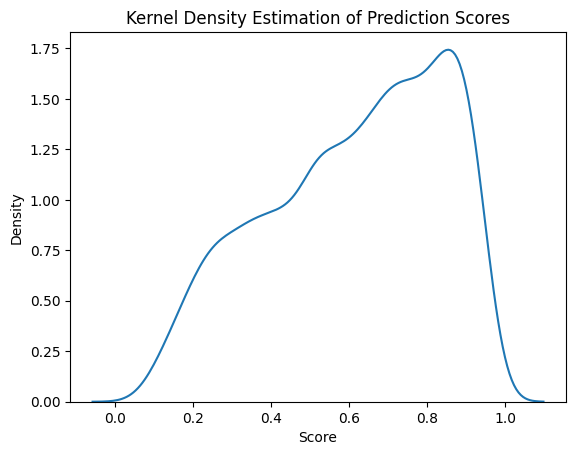

------------------------------------
Best threshold:  0.28983054
Best F1 score:  0.8547008547008547
####################################
XGB model evaluation for question 2
####################################
Training F1 Score: 0.9975826384550615
Validation F1 Score: 0.987736660929432
Training AUC Score: 0.9975884679997833
Validation AUC Score: 0.5367742139291958


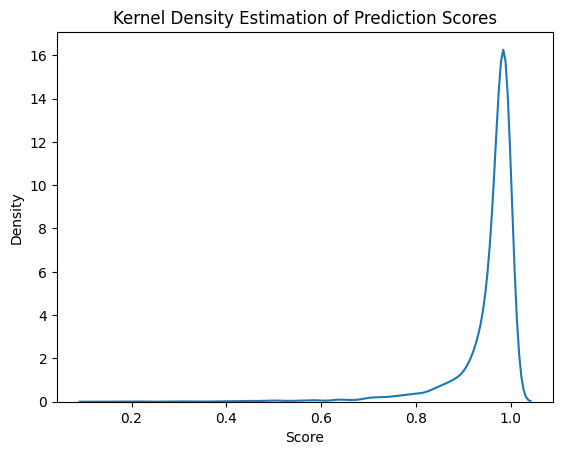

------------------------------------
Best threshold:  0.3089486
Best F1 score:  0.9891596007298488
####################################
XGB model evaluation for question 3
####################################
Training F1 Score: 0.9786778533198321
Validation F1 Score: 0.9417965169569203
Training AUC Score: 0.9790708241040496
Validation AUC Score: 0.6188026430438571


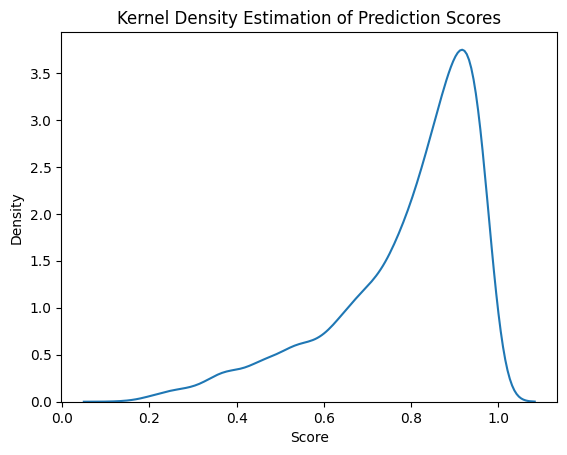

------------------------------------
Best threshold:  0.1418174
Best F1 score:  0.9656534620871283
####################################
XGB model evaluation for question 4
####################################
Training F1 Score: 0.8895831948414545
Validation F1 Score: 0.8625566387477688
Training AUC Score: 0.8898906198210144
Validation AUC Score: 0.7102210664257401


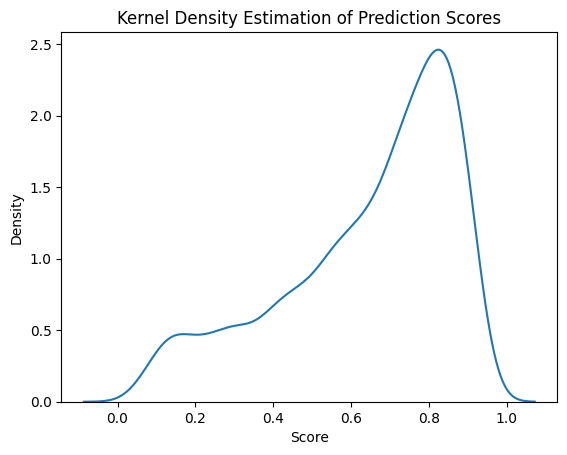

------------------------------------
Best threshold:  0.21386947
Best F1 score:  0.8956511026241223
####################################
XGB model evaluation for question 5
####################################
Training F1 Score: 0.8025767336112164
Validation F1 Score: 0.7089072543617998
Training AUC Score: 0.7985889629844399
Validation AUC Score: 0.6549855259100917


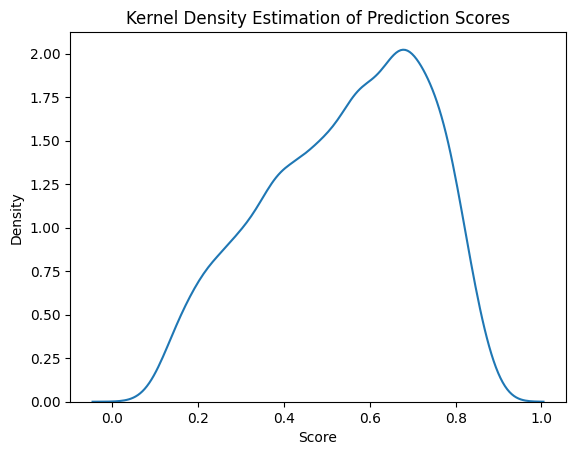

------------------------------------
Best threshold:  0.39052418
Best F1 score:  0.72568093385214
####################################
XGB model evaluation for question 6
####################################
Training F1 Score: 0.8724140316889227
Validation F1 Score: 0.843333791020184
Training AUC Score: 0.8736293859649124
Validation AUC Score: 0.6611195529825815


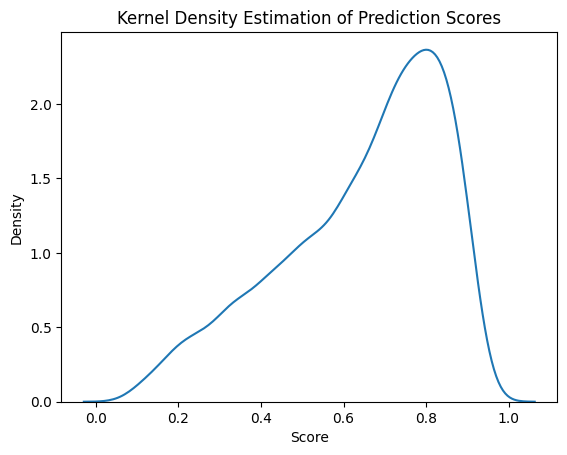

------------------------------------
Best threshold:  0.21240923
Best F1 score:  0.8844756599660936
####################################
XGB model evaluation for question 7
####################################
Training F1 Score: 0.8546197152003532
Validation F1 Score: 0.8101302883911579
Training AUC Score: 0.8574160952724648
Validation AUC Score: 0.6615436013855083


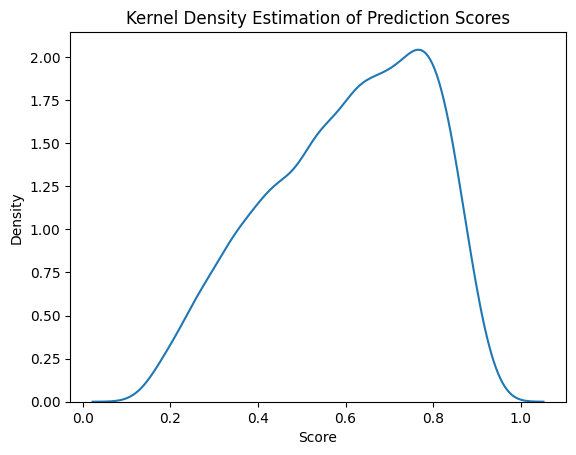

------------------------------------
Best threshold:  0.27353194
Best F1 score:  0.8530924601681095
####################################
XGB model evaluation for question 8
####################################
Training F1 Score: 0.842355740630577
Validation F1 Score: 0.6617021276595745
Training AUC Score: 0.8412630498031833
Validation AUC Score: 0.5795296903853813


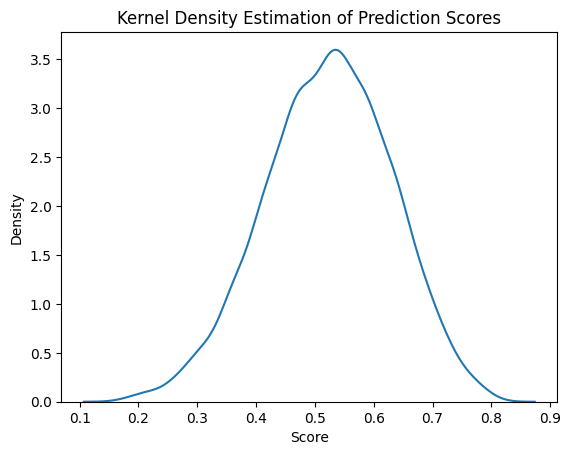

------------------------------------
Best threshold:  0.31889752
Best F1 score:  0.7575675675675676
####################################
XGB model evaluation for question 9
####################################
Training F1 Score: 0.860726643598616
Validation F1 Score: 0.8058449074074074
Training AUC Score: 0.8611370660533314
Validation AUC Score: 0.6346502108234071


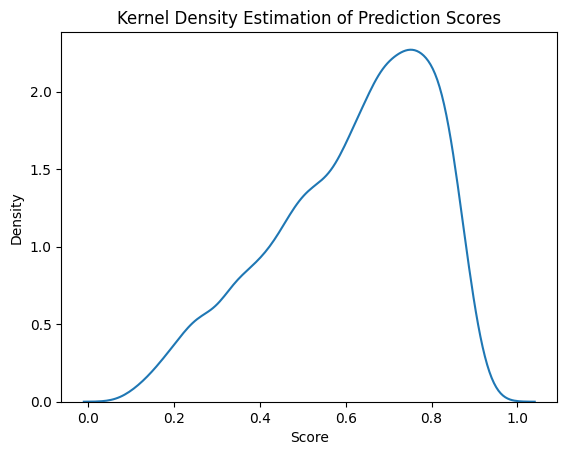

------------------------------------
Best threshold:  0.23052233
Best F1 score:  0.8471735867933966
####################################


In [15]:
warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     
best_threshold_dict = {}

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        df_train = df1_train
        df_valid = df1_valid
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        df_train = df2_train
        df_valid = df2_valid
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3_features
        df_train = df3_train
        df_valid = df3_valid
        FEATURES = FEATURES3
        
    #xgb_params['n_estimators'] =300 #estimators_xgb[t-1]
    #xgb_params = best_params_dict[t]
     
    # TRAIN DATA
    train_users = df_train.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # Validation DATA
    valid_users = df_valid.index.values.astype('int')
    valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

    
    X_train = df_train[FEATURES].astype('float32').fillna(-1)
    y_train = train_y['correct']

    # Use RandomOverSampler instead of SMOTE
    oversampler = RandomOverSampler(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)


    # smote = SMOTE(random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, train_y['correct'])

    clf =  XGBClassifier(**xgb_params)
    clf.fit(X_train, y_train, verbose = 0)
    # clf.save_model(f'XG_boost_models/230607/XGB_question{t}.xgb')
    # print(f'model XGB saved for question {t} with iterations = {estimators_xgb[t-1]}')


    

    #Evaluating the model
    print(f'XGB model evaluation for question {t}')
    

    print(f'####################################')

    # Variables
    #X_train = df_train[FEATURES].astype('float32')
    X_val = df_valid[FEATURES].astype('float32')
    #y_train = train_y['correct']
    y_val = valid_y['correct']

    X = df[FEATURES].astype('float32').fillna(-1)
    train_users = df.index.values
    y = targets.loc[targets.q==t].set_index('session').loc[train_users]['correct']

    # Make predictions
    y_train_preds = clf.predict(X_train)
    y_val_preds = clf.predict(X_val)

    # Calculate metrics
    # train_accuracy = accuracy_score(y_train, y_train_preds)
    # val_accuracy = accuracy_score(y_val, y_val_preds)

    # train_precision = precision_score(y_train, y_train_preds)
    # val_precision = precision_score(y_val, y_val_preds)

    # train_recall = recall_score(y_train, y_train_preds)
    # val_recall = recall_score(y_val, y_val_preds)

    train_f1 = f1_score(y_train, y_train_preds)
    val_f1 = f1_score(y_val, y_val_preds)

    train_auc = roc_auc_score(y_train, y_train_preds)
    val_auc = roc_auc_score(y_val, y_val_preds)

    # Print metrics
    # print(f"Training Accuracy: {train_accuracy}")
    # print(f"Validation Accuracy: {val_accuracy}")
    # print(f"Training Precision: {train_precision}")
    # print(f"Validation Precision: {val_precision}")
    # print(f"Training Recall: {train_recall}")
    # print(f"Validation Recall: {val_recall}")
    print(f"Training F1 Score: {train_f1}")
    print(f"Validation F1 Score: {val_f1}")
    print(f"Training AUC Score: {train_auc}")
    print(f"Validation AUC Score: {val_auc}")

    # Predict probabilities
    y_scores = clf.predict_proba(X_val)[:, 1]

    sns.kdeplot(y_scores)
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation of Prediction Scores')
    plt.show()

    # Calculate precision-recall values for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2*recalls*precisions / (recalls+precisions)

    # Locate the index of the largest F1 score
    best_index = np.argmax(f1_scores)

    # Find the best threshold and corresponding F1 score
    best_threshold = thresholds[best_index]
    best_f1 = f1_scores[best_index]

    best_threshold_dict[t] = best_threshold
    
    print(f'------------------------------------')
    print('Best threshold: ', best_threshold)
    print('Best F1 score: ', best_f1)

    print(f'####################################')

In [20]:
clf.predict_proba(X_val)#[:, 1]

array([[0.08445579, 0.9155442 ],
       [0.16602772, 0.8339723 ],
       [0.21029562, 0.7897044 ],
       ...,
       [0.01842266, 0.98157734],
       [0.02412975, 0.97587025],
       [0.2641344 , 0.7358656 ]], dtype=float32)

In [23]:
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold_dict, f)

print('Best threshold saved to best_threshold.pkl')

Best threshold saved to best_threshold.pkl


### Defining threshold

In [24]:
best_threshold_dict

{1: 0.16853307,
 2: 0.08227463,
 3: 0.05141823,
 4: 0.13998938,
 5: 0.31881723,
 6: 0.24884492,
 7: 0.12938134,
 8: 0.2956119,
 9: 0.8952315,
 10: 0.7675504,
 11: 0.26448527,
 12: 0.10502062,
 13: 0.33294398,
 14: 0.2814991,
 15: 0.8630352,
 16: 0.28296673,
 17: 0.28541926,
 18: 0.14577042}

# Exporting final models

In [25]:
warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3_features
        FEATURES = FEATURES3
        
    #xgb_params['n_estimators'] =300 #estimators_xgb[t-1]
    #xgb_params = best_params_dict[t]
     
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    
    X_train = df[FEATURES].astype('float32').fillna(-1)
    y_train = train_y['correct']

    # Use RandomOverSampler instead of SMOTE
    oversampler = RandomOverSampler(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # #SMOTE
    # smote = SMOTE(random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, train_y['correct'])



    clf =  XGBClassifier(**xgb_params)
    clf.fit(X_train, y_train, verbose = 1)
    clf.save_model(f'XG_boost_models/230611/XGB_question{t}.xgb')
    print(f'model XGB saved for question {t}')

model XGB saved for question 1
model XGB saved for question 2
model XGB saved for question 3
model XGB saved for question 4
model XGB saved for question 5
model XGB saved for question 6
model XGB saved for question 7
model XGB saved for question 8
model XGB saved for question 9
model XGB saved for question 10
model XGB saved for question 11
model XGB saved for question 12
model XGB saved for question 13
model XGB saved for question 14
model XGB saved for question 15
model XGB saved for question 16
model XGB saved for question 17
model XGB saved for question 18


# Submission

In [ ]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [ ]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

count = 0

for (sample_submission, test) in iter_test:
        
        session_id = test.session_id.values[0]
        grp = test.level_group.values[0]
        a,b = limits[grp]
  

        # ------------------- level 0-4 ---------------------------------
        if a == 1:
            FEATURES = FEATURES1
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            

        # ------------------- level 5-12 ---------------------------------
        elif a == 4:
            FEATURES = FEATURES2
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]

        # ------------------- level 13-22 ---------------------------------    
        elif a == 14:
            FEATURES = FEATURES3
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
    
        for t in range(a,b):

            clf = XGBClassifier()
            clf.load_model(f'/kaggle/working/XGB_question{t}.xgb')

            mask = sample_submission.session_id.str.contains(f'q{t}')
            p = clf.predict_proba(test.astype('float32'))[:,1]
            sample_submission.loc[mask,'correct'] = int((p.item())>0.625)  
                
        env.predict(sample_submission)

In [ ]:
pd.read_csv('submission.csv').head(10)

# DEBUG

### Usefull when you make updates

In [ ]:
"""
test = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/test.csv')
test = test.drop('session_level', axis=1)
test_level1 = test[test['level_group'] == '0-4']
test_level2 = test[test['level_group'] == '5-12']
test_level3 = test[test['level_group'] == '13-22']
sample_submission = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv')

limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}


for test_level in [test_level1,test_level2,test_level3]:
    l = np.unique(test_level['level_group']).tolist()
    print(f'\n***************** level = {l}*******************\n')
    for session_id in [20090109393214576,20090312143683264,20090312331414616]:
        print(f'--------- {session_id} ---------')
        
        test_level_session = test_level[test_level['session_id']==session_id]          
        #display(test_level_session.head(2))
        #------------------------------------
        #grp = test.level_group.values[0]
        grp = l[0] 
        a,b = limits[grp]
        #------------------------------------           
        columns = [

            pl.col("page").cast(pl.Float32),
            (
                (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
                 .fill_null(0)
                 .clip(0, 1e9)
                 .over(["session_id", "level_group"])
                 .alias("elapsed_time_diff")
            ),
            (
                (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
                 .abs()
                 .over(["session_id", "level_group"])
                .alias("location_x_diff") 
            ),
            (
                (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
                 .abs()
                 .over(["session_id", "level_group"])
                .alias("location_y_diff") 
            ),
            pl.col("fqid").fill_null("fqid_None"),
            pl.col("text_fqid").fill_null("text_fqid_None")
        ]

        # ------------------- level 0-4 ---------------------------------
        if a == 1:
            print('GRP =',grp)
            FEATURES = FEATURES1
            
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            level = 3
            w = 0
            print('test shape',test_level.shape)
            print('level =',level)
          
            scaler = scaler_0

        # ------------------- level 5-12 ---------------------------------
        elif a == 4:
            print('GRP =',grp)
            FEATURES = FEATURES2
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            print('test shape',test.shape) # **********************
            level = 10 
            print('level =',level)
            scaler = scaler_1

        # ------------------- level 13-22 ---------------------------------    
        elif a == 14:
            print('GRP =',grp)
            FEATURES = FEATURES3
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            print('test shape',test.shape) # **********************
            
            level = 5
            print('level =',level)
            scaler = scaler_2
         

        # ---------- Predictions for the session_id and the level_group -------------    

        X_test = scaler.transform(test)
        #X_test = scaler.transform(test)
        
        X_test = torch.from_numpy(X_test.astype(np.float32))
        pred_test = np.zeros((X_test.shape[0],level))

        for i in range(N_SPLITS) :
            with torch.no_grad():
                model = dict_level[level][i]
                model.eval()
                pred = model(X_test.float())
                pred_test += pred.numpy()/N_SPLITS
               
      
        pred_test = pred_test.tolist()[0]
        print(pred_test)           
            
        for t in range(a,b):
            w = t-a
            print(f'---------- t = {t} ----  t-a = {w} -------------')
            mask = sample_submission.session_id.str.contains(f'q{t}')
            sample_submission.loc[mask,'correct'] = int(pred_test[w]>0.61) 
            print('prediction = ',int(pred_test[w]>0.61))                  
           
        #env.predict(sample_submission)
           
"""